# Preliminary Information

The aim is to analyze a dataset containing credit card transactions and develop a model that minimizes errors.


Confusion matrix (order based on the sklearn library):

$$
\begin{bmatrix}
    \text{TN} & \text{FP} \\
    \text{FN} & \text{TP}
\end{bmatrix}
$$

where::
- TN - true negative, which is class 0 correctly predicted as class 0
- FP - false positive, which is class 0 incorrectly predicted as class 1
- FN - false negative, which is class 1 incorrectly predicted as class 0
- TP - true positive, which is class 1 correctly predicted as class 1

(Here, note that class 1 represents fraud, and class 0 represents a legitimate transaction)

The goal is to minimize mistakes.

# Loading libraries, data, and custom functions

Loading libraries

In [1]:
# Essentials
import time 
import numpy as np
import pandas as pd

# Docker connection
import sqlalchemy
from urllib.parse import quote_plus

# Plots
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib.colors import ListedColormap

# Models
import statsmodels.api as sm 
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

Data loading

In [2]:
card_fraud = pd.read_csv("csv_files/creditcard.csv", delimiter = ",")

Custom functions loading

In [3]:
# ROC Curve

def plot_roc(y_test, predictions):
    fig, ax = plt.subplots()
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
    ax.set_xlabel('Specificity')
    ax.set_ylabel('Sensitivity')
    ax.plot([0, 1], [0, 1], linestyle='--', label='Random classifier', linewidth = 1)
    ax.legend(loc='lower right', fontsize='small', frameon=True)
    return fpr, tpr, thresholds
    
# Function to find the threshold for the minimum sum of errors

def find_threshold_errors(thresholds, model):
    best_threshold = min(thresholds)
    assigned_classes = [0 if element < best_threshold else 1 for element in model.predict(x_test).to_numpy()]
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, assigned_classes).ravel()
    smallest_sum_of_errors = fp + fn
    for threshold in thresholds:
        assigned_classes = [0 if element < threshold else 1 for element in model.predict(x_test).to_numpy()]
        tn, fp, fn, tp = metrics.confusion_matrix(y_test, assigned_classes).ravel()
        current_sum_of_errors = fp + fn
        if current_sum_of_errors < smallest_sum_of_errors:
            smallest_sum_of_errors = current_sum_of_errors
            best_threshold = threshold

    print("Best threshold for the smallest sum of errors:", round(best_threshold, 3))
    
# Function to find the threshold for the best precision

def find_threshold_precision(thresholds, model):
    best_threshold = min(thresholds)
    assigned_classes = [0 if element < best_threshold else 1 for element in model.predict(x_test).to_numpy()]
    best_precision = metrics.precision_score(y_test, assigned_classes, zero_division=np.nan)
    for threshold in thresholds:
        assigned_classes = [0 if element < threshold else 1 for element in model.predict(x_test).to_numpy()]
        current_precision = metrics.precision_score(y_test, assigned_classes, zero_division=np.nan)
        if current_precision > best_precision:
            best_precision = current_precision
            best_threshold = threshold

    print("Best threshold for the best precision:", round(best_threshold, 3))

# Confusion matrix with details    
    
def plot_matrix(y_test, predictions):
    cm = metrics.confusion_matrix(y_test, predictions)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
    conf_matrix = cm
    total = sum(conf_matrix.ravel())
    tn, fp, fn, tp = conf_matrix.ravel()
    accuracy = (tn + tp) / total
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1_score = 2 * (precision * recall) / (precision + recall)

    print("Sum of errors (FP + FN):", fp + fn)
    print("Accuracy:", round(accuracy, 3))
    print("Precision:", round(precision, 3))
    print("Recall:", round(recall, 3))
    print("Specificity:", round(specificity, 3))
    print("F1 Score:", round(f1_score, 3))

    fig, ax_1 = plt.subplots()
    cm_display.plot(colorbar=False, ax=ax_1, values_format='.0f', cmap = 'magma')
    cm_display.figure_ = fig
    plt.show()

# Data splitting

 - x - explanatory variables
 - y - response variable

In [4]:
x = card_fraud.iloc[:, :-1]
y = card_fraud.iloc[:, -1]

In [5]:
x.head(5), y.head(5)

(   Time        V1        V2        V3        V4        V5        V6        V7  \
 0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
 1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
 2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
 3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
 4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   
 
          V8        V9  ...       V20       V21       V22       V23       V24  \
 0  0.098698  0.363787  ...  0.251412 -0.018307  0.277838 -0.110474  0.066928   
 1  0.085102 -0.255425  ... -0.069083 -0.225775 -0.638672  0.101288 -0.339846   
 2  0.247676 -1.514654  ...  0.524980  0.247998  0.771679  0.909412 -0.689281   
 3  0.377436 -1.387024  ... -0.208038 -0.108300  0.005274 -0.190321 -1.175575   
 4 -0.270533  0.817739  ...  0.408542 -0.009431  0.798278 -0.137458  0.141267   
 
         V25      

Splitting data into training and testing sets

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x,y, stratify = y, test_size = 0.25, random_state = 42)

In [7]:
print("Sum of rows in the dataset: {}".format(len(card_fraud)))
print("Sum of frauds in the dataset: {}".format(sum(y_test) + sum(y_train)))
print("Number of rows in the training set: {}".format(len(x_train)))
print("Number of rows in the testing set: {}".format(len(x_test)))
print("Number of frauds in the training set: {}".format(sum(y_train)))
print("Number of frauds in the testing set: {}".format(sum(y_test)))
print("Percentage of frauds in the dataset: {}%".format(round(100*(sum(card_fraud.iloc[:, -1]))/len(card_fraud), 2)))

Sum of rows in the dataset: 284807
Sum of frauds in the dataset: 492
Number of rows in the training set: 213605
Number of rows in the testing set: 71202
Number of frauds in the training set: 369
Number of frauds in the testing set: 123
Percentage of frauds in the dataset: 0.17%


## Histogram with Class Division

A significant class imbalance is observed.

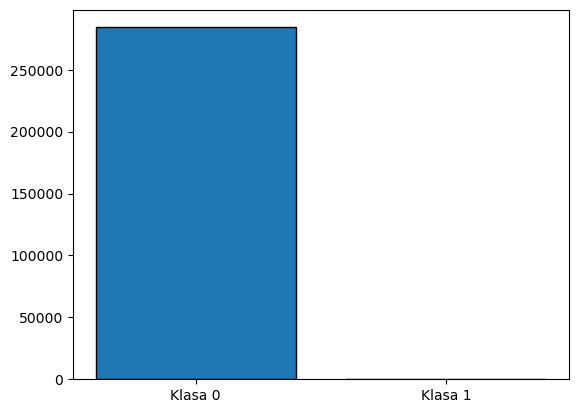

In [8]:
fig, ax = plt.subplots()

bars = plt.bar([0, 1], [len(y[y == 0]), len(y[y == 1])])
plt.xticks([0, 1], ['Class 0', 'Class 1'])

for bar in bars:
    bar.set_edgecolor('black')

# Show the plot
plt.show()

# Logistic regression

In [9]:
model = sm.Logit(y_train, x_train).fit()

Optimization terminated successfully.
         Current function value: 0.009723
         Iterations 15


In [10]:
predictions = model.predict(x_test)

## ROC curve

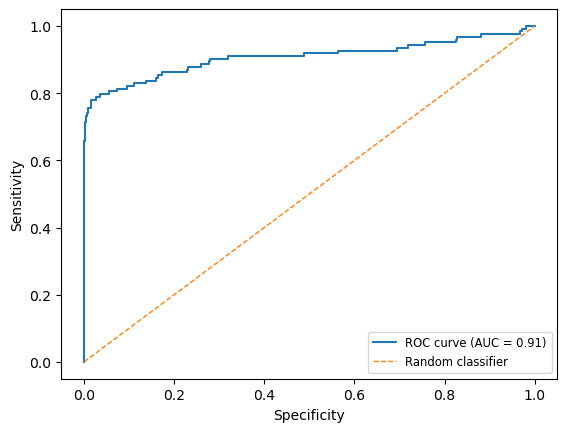

In [11]:
fpr, tpr, thresholds = plot_roc(y_test, predictions)

AUC = 0.91 means, that the model has very good discrimination capabilities.

Let's try to find optimal threshold. The closest to the point (0,1)

In [12]:
optimal_index = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_index]
fpr_val = round(fpr[optimal_index], 3)
tpr_val = round(tpr[optimal_index], 3)
print("Classification threshold value:", round(optimal_threshold, 3))
print("Point (x, y) on the ROC curve: ({}, {})".format(fpr_val, tpr_val))

Classification threshold value: 0.026
Point (x, y) on the ROC curve: (0.016, 0.78)


I copied above, to show it in the ROC Curve plot below

In [13]:
def plot_roc_2(y_test, predictions):
    fig, ax = plt.subplots()
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
    ax.set_xlabel('Specificity')
    ax.set_ylabel('Sensitivity')
    ax.plot([0, 1], [0, 1], linestyle='--', label='Random classifier', linewidth=1)
    
    # Adding a line
    ax.plot([0, 0.016], [1, 0.78], linestyle='--', label='Shortest distance to point (0,1)', linewidth=1)
    ax.text(0.05, 0.75, 'Classification threshold = 0.026', fontsize='small', ha='left', va='bottom')

    ax.legend(loc='lower right', fontsize='small', frameon=True)
    plt.show()
    return fpr, tpr, thresholds

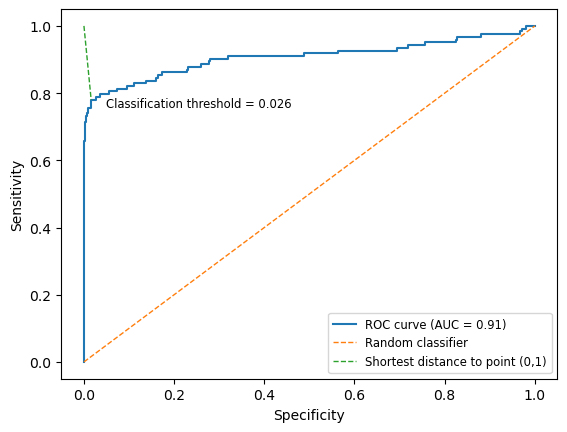

In [14]:
fpr, tpr, thresholds = plot_roc_2(y_test, predictions)

Confusion matrix for threshold above

Sum of errors (FP + FN): 1172
Accuracy: 0.984
Precision: 0.077
Recall: 0.772
Specificity: 0.984
F1 Score: 0.14


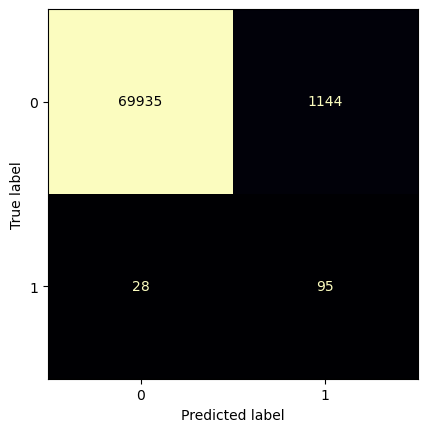

In [15]:
threshold_0 = 0.026
predictions_0 = [0 if element < threshold_0 else 1 for element in model.predict(x_test)]
plot_matrix(y_test, predictions_0)

There is a lot of FP, let's try with default threshold 0.5.

## Model 1

Threshold = 0.5

Sum of errors (FP + FN): 83
Accuracy: 0.999
Precision: 0.675
Recall: 0.626
Specificity: 0.999
F1 Score: 0.65


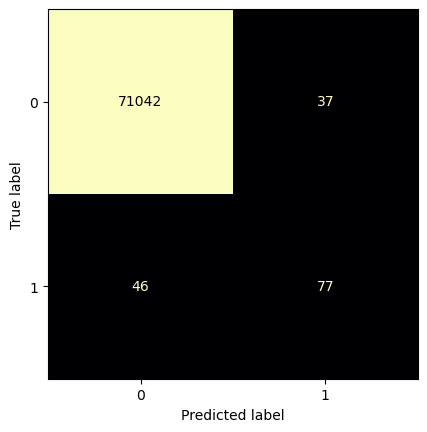

In [16]:
threshold_1 = 0.5
predictions_1 = [0 if element < threshold_1 else 1 for element in model.predict(x_test)]
plot_matrix(y_test, predictions_1)

Sum of errors is over 1000 less than before, but there's more FN values. Let's try to minimalise the number of FN values, by maximalizing precision.

## Model 2


From the function for optimizing the classification threshold (based on the best precision), the following result is obtained:

In [17]:
find_threshold_precision(np.arange(0.00, 1.01, 0.01), model)

Best threshold for the best precision: 0.97


Sum of errors (FP + FN): 76
Accuracy: 0.999
Precision: 0.822
Recall: 0.488
Specificity: 1.0
F1 Score: 0.612


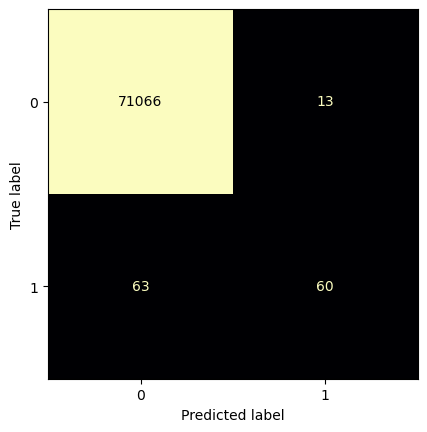

In [18]:
threshold_2 = 0.97
predictions_2 = [0 if element < threshold_2 else 1 for element in model.predict(x_test)]
plot_matrix(y_test, predictions_2)

The sum of errors is lower, but the values of false negatives (FN) have increased. This could be due to the specificity of the data.

## Model 3

The previous step will be repeated, but a different threshold optimization function will be used. This time, I want to minimize the sum of errors (regardless of whether FP or FN).

In [19]:
find_threshold_errors(np.arange(0.00, 1.01, 0.01), model)

Best threshold for the smallest sum of errors: 0.86


Sum of errors (FP + FN): 71
Accuracy: 0.999
Precision: 0.789
Recall: 0.577
Specificity: 1.0
F1 Score: 0.667


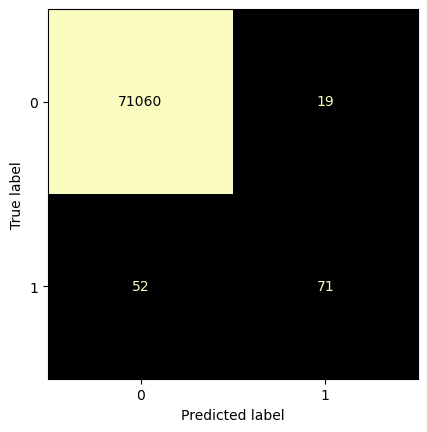

In [20]:
threshold_3 = 0.86
predictions_3 = [0 if element < threshold_3 else 1 for element in model.predict(x_test)]
plot_matrix(y_test, predictions_3)

Sum of errors is equal to 71. Logistic regression is done.

# Random forest

Finally, the Random Forest method is tested.

`n_jobs` is responsible for the number of jobs to run in parallel. `-1` means using all processors.

Execution time for me is around 1.5 minute. Without `n_jobs` it's around 8 minutes.

In [21]:
time_1 = time.time()

model_forest = RandomForestClassifier(random_state=42, n_jobs=-1)
model_forest = model_forest.fit(x_train, y_train)
predictions_forest = model_forest.predict(x_test)

time_2 = time.time()

print("Execution time: ", time_2 - time_1)

Execution time:  94.59939956665039


Plotted results below

Sum of errors (FP + FN): 30
Accuracy: 1.0
Precision: 0.943
Recall: 0.805
Specificity: 1.0
F1 Score: 0.868


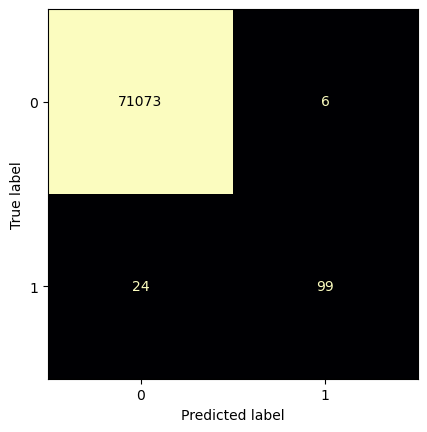

In [22]:
plot_matrix(y_test,predictions_forest)

There is only 30 errors. That's 2 times less than the best logistic regression model.

Below is tested the same fuction, with additional parameters, to decrease execution time.

`n_estimators` - The number of trees in the forest.

`max_depth` - The maximum depth of the tree.

In [24]:
time_1 = time.time()

model_forest_2 = RandomForestClassifier(random_state = 42, n_jobs = -1, n_estimators=32, max_depth = 16)
model_forest_2 = model_forest.fit(x_train,y_train)
predictions_forest_2 = model_forest.predict(x_test)

time_2 = time.time()

print("Execution time: ", time_2 - time_1)

Execution time:  25.641037225723267


Execution time is less than half a minute. Results below.

Sum of errors (FP + FN): 33
Accuracy: 1.0
Precision: 0.95
Recall: 0.772
Specificity: 1.0
F1 Score: 0.852


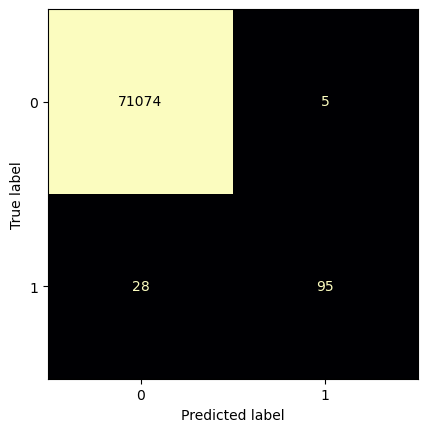

In [25]:
plot_matrix(y_test,predictions_forest_2)

Results are a bit worse, but execution time is better.

# Conclusions 
The Random Forest method (1st model) proved to be the most effective in this dataset.

Model characteristics:

- 94.3% of fraud cases are correctly identified (precision);
- 19.5% of frauds are incorrectly classified as legitimate transactions (recall);
- 86.8% effectiveness in identifying frauds (F1-score).

# Docker Connection

I establish a connection with the Docker container containing the database. Using SQL, I retrieve the transactions table from the `card_fraud` database.

In [27]:
engine = sqlalchemy.create_engine("mariadb+mariadbconnector://root:%s@127.0.0.1:3308/card_fraud" % quote_plus("p@ssw0rd"))
# quote_plus is used, because "@" occurs in password, and it didn't work without it

with engine.begin() as conn:
    query = sqlalchemy.text("SELECT * FROM transactions_details")
    transactions = pd.read_sql_query(query, conn)

Display the table

In [28]:
transactions.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,1,39666,-5.935260,4.952580,0.119860,-2.173710,0.273927,-0.534900,2.486460,-1.942650,...,-1.662530,-0.980118,-0.139782,-0.168372,1.002020,-0.105004,1.409160,-0.358338,8.95,0
1,2,135639,1.895330,0.508860,-0.696972,3.807420,0.298988,-0.393361,0.258127,-0.197562,...,0.306400,0.899620,-0.006970,0.052034,0.177626,0.215902,-0.043071,-0.048397,27.08,0
2,3,37650,-1.193190,1.283840,1.228260,1.433260,0.071067,-0.667199,2.056660,-0.424263,...,0.038079,0.149288,-0.073241,0.704165,0.447911,-0.119020,-0.105883,0.001187,158.00,0
3,4,64252,-2.841140,-1.750860,1.373920,2.847720,0.906127,0.309098,-0.684485,1.040360,...,0.690891,0.646321,0.415398,-0.302572,-0.396616,0.124540,0.004519,-0.279409,220.59,0
4,5,30199,-0.652836,0.876966,-0.127812,-0.065732,2.082540,3.877990,-0.348853,1.418890,...,-0.153581,-0.570733,-0.063886,0.985816,-0.003125,-0.472128,0.042032,0.069742,16.13,0


Below is a function that, for each record, makes predictions and adds a row to the appropriate table in the database.

Note! Running the cell below requires training the first `Random Forest` model (this takes about 1.5 minutes). Commened line is responsible for 2nd model, that requires ~ 30 secs to execute.

In [29]:
def insert_data(transactions):
    for i in range(len(transactions)):
        row = None
        predict = model_forest.predict((transactions.iloc[i:i+1, 1:31]))
        # predict = model_forest.predict((transactions.iloc[i:i+1, 1:31]))
        row = transactions.iloc[i:i+1, 0]
        if predict == 0:
            with engine.begin() as conn:
                row.to_sql('predicted_not_fraud', conn, if_exists='append', index = False)
        else:
            with engine.begin() as conn:
                row.to_sql('predicted_fraud', conn, if_exists='append', index = False)

Starting the function

In [30]:
start_time = time.time()
insert_data(transactions.head(5))

end_time = time.time()

print(f"Execution time: {end_time - start_time}")

Execution time: 0.08590865135192871


In [33]:
with engine.begin() as conn:
    query = sqlalchemy.text("SELECT * FROM predicted_not_fraud")
    test = pd.read_sql_query(query, conn)
    
test

,id,prediction
0,1,Not fraud
1,2,Not fraud
2,3,Not fraud
3,4,Not fraud
4,5,Not fraud
